In [90]:
import json
from collections import defaultdict
from sklearn import linear_model, metrics
from sklearn.metrics import precision_score
import numpy as np
import random
import gzip
import dateutil.parser
import math
import matplotlib.pyplot as plt
import string
import re
from nltk.stem.snowball import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import lil_matrix
from gensim.models import Word2Vec
import tensorflow as tf

In [91]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))

In [92]:
len(dataset)

192544

In [93]:
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

## Data Cleaning

In [94]:
data = dataset

In [95]:
# Drop all ratings having null values
data = [d for d in dataset if d['rating'] != None]
print(len(data), len(dataset))

192462 192544


In [96]:
# Drop all 'age' having null values
data = [d for d in data if 'age' in d]
print(len(data), len(dataset))

191503 192544


In [97]:
# Drop all 'weight' having null values
data = [d for d in data if 'weight' in d]
print(len(data), len(dataset))

162153 192544


In [98]:
# Drop all 'height' having null values
data = [d for d in data if 'height' in d]
print(len(data), len(dataset))

161716 192544


In [99]:
# Drop all 'body type' having null values
data = [d for d in data if 'body type' in d and d['body type'] != None]
print(len(data), len(dataset))

153110 192544


In [100]:
# Drop all 'rented for' having null values
data = [d for d in data if 'rented for' in d and d['body type'] != None]
print(len(data), len(dataset))

153100 192544


In [101]:
for d in data:
    # Convert 'rating' from string to int and change from 2,4,6,8,10 to 1,2,3,4,5
    d['rating'] = int(d['rating']) // 2
    # Convert 'age' from string to int
    d['age'] = int(d['age'])
    # Drop 'lbs' unit and convert 'weight' from str to int
    d['weight'] = int(d['weight'][:-3])
    # Drop unit and convert 'height' from str to int
    feet,inch = re.findall(r'\d+', d['height'])
    d['height'] = int(feet) * 12 + int(inch)

In [102]:
# Pre-processing 'review_text' by ignoring capitalization and removing punctuation
sp = set(string.punctuation)
def cleanText(text):
    text = ''.join([c for c in text.lower() if not c in sp])
    return text

In [103]:
data[68]

{'fit': 'fit',
 'user_id': '203660',
 'bust size': '34c',
 'item_id': '1126889',
 'weight': 160,
 'rating': 3,
 'rented for': 'party',
 'review_text': "The dress is absolutely gorgeous, unfortunately the dress proportions were off for my height. I would have loved to wear this out, but I couldn't because the lengths were awkward on my body. ",
 'body type': 'athletic',
 'review_summary': 'Too Long',
 'category': 'dress',
 'height': 64,
 'size': 12,
 'age': 28,
 'review_date': 'January 3, 2017'}

In [104]:
print(len(data), len(dataset)) 

153100 192544


# Latent Factor Model using TensorFlow

In [105]:
# Train-valid and test split is 8/2
# Train and valid split is 8/2 
trainValidRatio = 0.8
trainRatio = 0.8
NTrainValid = int(len(data) * trainValidRatio)
NTrain = int(NTrainValid * trainRatio)
trainValidSet = data[:NTrainValid]
trainSet = trainValidSet[:NTrain]
validSet = trainValidSet[NTrain:]
testSet = data[NTrainValid:]

In [106]:
# Assign IDs
userIds = {}
itemIds = {}

for d in dataset:
    u = d['user_id']
    i = d['item_id']
    c = d['category']
    f = d['fit']
    if u not in userIds: userIds[u] = len(userIds)
    if i not in itemIds: itemIds[i] = len(itemIds)

In [107]:
trainAvgRating = sum([d['rating'] for d in trainSet]) / len(trainSet)

In [108]:
class BaseLFRegression(tf.keras.Model):
    def __init__(self, K, lamb1, lamb2, lossFun, optim):
        super(BaseLFRegression, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(trainAvgRating)
        # Initialize to small random values
        numUsers = len(userIds)
        numItems = len(itemIds)
        self.betaU = tf.Variable(tf.random.normal([numUsers], stddev=1e-3))
        self.betaI = tf.Variable(tf.random.normal([numItems], stddev=1e-3))
        self.gammaU = tf.Variable(tf.random.normal([numUsers, K], stddev=1e-3))
        self.gammaI = tf.Variable(tf.random.normal([numItems, K], stddev=1e-3))
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        self.lossFun = lossFun
        self.optim = optim

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        # alpha + betaU + betaI + gammaU dot gammaI
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def regularize(self):
        return self.lamb1 * (tf.reduce_sum(self.betaU**2) + tf.reduce_sum(self.betaI**2)) +\
                self.lamb2 * (tf.reduce_sum(self.gammaU**2) + tf.reduce_sum(self.gammaI**2))
    
    # Loss
    def call(self, sampleU, sampleI, sampleY):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        y = tf.convert_to_tensor(sampleY, dtype=tf.float32)
        return self.lossFun(y, pred)
    
    def trainingStep(self, UBatch, IBatch, YBatch):
        with tf.GradientTape() as tape:
            # Compute loss(objective value)
            loss = self(UBatch, IBatch, YBatch) + self.regularize()
            # Do gradient descent
            gradients = tape.gradient(loss, self.trainable_variables)
            self.optim.apply_gradients((grad, var)
                                    for (grad, var) in zip(gradients, self.trainable_variables)
                                    if grad is not None)
        return loss.numpy()
    
    def getBatches(self, batchSize, trainSet):
        UBatches, IBatches, YBatches = [], [], []
        numBatches = len(trainSet) // batchSize
        for i in range(numBatches):
            size = len(trainSet) - i*batchSize
            batch = trainSet[i*batchSize : (i+1)*batchSize] if size > batchSize else trainSet[i*batchSize :]
            UBatch, IBatch, YBatch = [], [], []
            for d in batch:
                UBatch.append(userIds[d['user_id']])
                IBatch.append(itemIds[d['item_id']])
                # The ratings are always even
                YBatch.append(d['rating'])
            UBatches.append(UBatch)
            IBatches.append(IBatch)
            YBatches.append(YBatch)
        return UBatches, IBatches, YBatches
    
    def train(self, epochs, batchSize, trainSet, validSet):
        trainLosses = []
        validLosses = []
        UBatches, IBatches, YBatches = self.getBatches(batchSize, trainSet)
        numBatches = len(UBatches)
        for i in range(epochs):
            trainLoss = 0.
            i = 0
            for j in range(numBatches):
                trainLoss += self.trainingStep(UBatches[j], IBatches[j], YBatches[j])
                i += 1
            trainLosses.append(trainLoss / i)
            validLoss = self.eval(validSet)
            validLosses.append(validLoss)
            print(f"epoch {i+1}, validation objective = {validLoss}")
        return trainLosses, validLosses

    def eval(self, testSet):
        pred, y = [], []
        for d in testSet:
            # The ratings are always even
            p = self.predict(userIds[d['user_id']], itemIds[d['item_id']])
            pred.append(p)
            y.append(d['rating'])
        loss = self.lossFun(tf.convert_to_tensor(y), tf.convert_to_tensor(pred))
        return loss.numpy()

epoch 245, validation objective = 0.4916999638080597
epoch 245, validation objective = 0.48932525515556335
epoch 245, validation objective = 0.4904782772064209


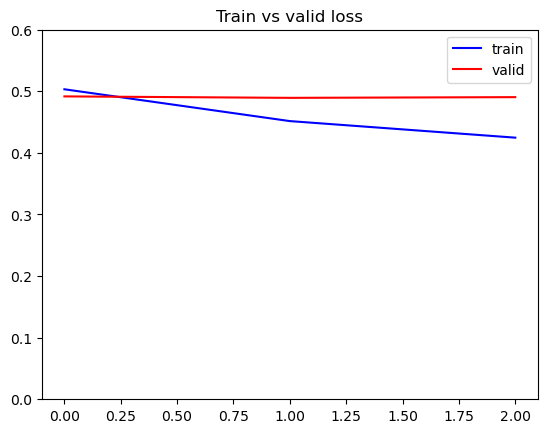

In [112]:
lossFun = tf.keras.metrics.mean_squared_error
optim = tf.keras.optimizers.Adam(5e-3)
model = BaseLFRegression(K=5, lamb1=2.3e-5, lamb2=2.3e-4, lossFun=lossFun, optim=optim)
trainLosses, validLosses = model.train(3, 400, trainSet, validSet)
plt.plot(trainLosses, 'b')
plt.plot(validLosses, 'r')
plt.legend(['train', 'valid'])
plt.title('Train vs valid loss')
plt.ylim(0., 0.6)
plt.show()

In [110]:
model.eval(testSet)

0.4918902